In [1]:
import torch
import torchvision
from torchvision import datasets,transforms, models
import os
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable 
import time
%matplotlib inline

数据载入

In [2]:
path = "dog_vs_cat"
transform = transforms.Compose([transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])])

data_image = {x:datasets.ImageFolder(root = os.path.join(path,x),
                                     transform = transform)
              for x in ["train", "val"]}

data_loader_image = {x:torch.utils.data.DataLoader(dataset=data_image[x],
                                                batch_size = 4,
                                                shuffle = True)
                     for x in ["train", "val"]}

In [3]:
use_gpu = torch.cuda.is_available()
print(use_gpu)

True


查看训练数据的类别

In [4]:
classes = data_image["train"].classes
classes_index = data_image["train"].class_to_idx
print(classes)
print(classes_index)

['cat', 'dog']
{'cat': 0, 'dog': 1}


0代表的是猫 1代表的狗

数据集个数

In [5]:
print(u"训练集个数:", len(data_image["train"]))
print(u"验证集个数:", len(data_image["val"]))

训练集个数: 20000
验证集个数: 5000


预览训练集合

['cat', 'cat', 'cat', 'cat']


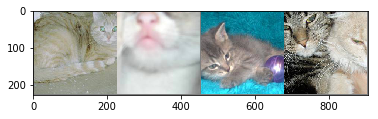

In [6]:
X_train, y_train = next(iter(data_loader_image["train"]))
mean = [0.5,0.5,0.5]
std  = [0.5,0.5,0.5]
img = torchvision.utils.make_grid(X_train)
img = img.numpy().transpose((1,2,0))
img = img*std+mean

print([classes[i] for i in y_train])
plt.imshow(img)

In [7]:
model = models.vgg16(pretrained=True)

In [8]:
print(model)

VGG (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU (inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU (inplace)
    (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU (inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU (inplace)
    (16): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), pa

In [9]:
for parma in model.parameters():
    parma.requires_grad = False

model.classifier = torch.nn.Sequential(torch.nn.Linear(25088, 4096),
                                       torch.nn.ReLU(),
                                       torch.nn.Dropout(p=0.5),
                                       torch.nn.Linear(4096, 4096),
                                       torch.nn.ReLU(),
                                       torch.nn.Dropout(p=0.5),
                                       torch.nn.Linear(4096, 2))

    
if use_gpu:
    model = model.cuda()


cost = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters())

In [10]:
print(model)

VGG (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU (inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU (inplace)
    (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU (inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU (inplace)
    (16): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), pa

In [11]:

n_epochs = 1
for epoch in range(n_epochs):
    since = time.time()
    print("Epoch{}/{}".format(epoch, n_epochs))
    print("-"*10)
    for param in ["train", "val"]:
        if param == "train":
            model.train = True
        else:
            model.train = False

        running_loss = 0.0
        running_correct = 0 
        batch = 0
        for data in data_loader_image[param]:
            batch += 1
            X, y = data
            if use_gpu:
                X, y  = Variable(X.cuda()), Variable(y.cuda())
            else:
                X, y = Variable(X), Variable(y)
        
            optimizer.zero_grad()
            y_pred = model(X)
            _, pred = torch.max(y_pred.data, 1)
        
            loss = cost(y_pred, y)
            if param =="train":
                loss.backward()
                optimizer.step()
            running_loss += loss.data[0]
            running_correct += torch.sum(pred == y.data)
            if batch%500 == 0 and param =="train":
                print("Batch {}, Train Loss:{:.4f}, Train ACC:{:.4f}".format(
                      batch, running_loss/(4*batch), 100*running_correct/(4*batch)))
            
        epoch_loss = running_loss/len(data_image[param])
        epoch_correct = 100*running_correct/len(data_image[param])

        print("{}  Loss:{:.4f},  Correct{:.4f}".format(param, epoch_loss, epoch_correct))
    now_time = time.time() - since   
    print("Training time is:{:.0f}m {:.0f}s".format(now_time//60, now_time%60))

Epoch0/1
----------
Batch 500, Train Loss:0.8073, Train ACC:88.4500
Batch 1000, Train Loss:1.0141, Train ACC:89.9500
Batch 1500, Train Loss:0.8976, Train ACC:91.2333
Batch 2000, Train Loss:0.8154, Train ACC:91.9500
Batch 2500, Train Loss:0.7552, Train ACC:92.3500
Batch 3000, Train Loss:0.6801, Train ACC:92.8083
Batch 3500, Train Loss:0.6457, Train ACC:93.0500
Batch 4000, Train Loss:0.6467, Train ACC:93.1875
Batch 4500, Train Loss:0.6263, Train ACC:93.3722
Batch 5000, Train Loss:0.5983, Train ACC:93.4950
train  Loss:0.5983,  Correct93.4950
val  Loss:0.4096,  Correct95.8400
Training time is:32m 11s


In [12]:
torch.save(model.state_dict(), "model_vgg16_finetune.pkl")

In [13]:
data_test_img = datasets.ImageFolder(root="test",
                                     transform = transform)
data_loader_test_img = torch.utils.data.DataLoader(dataset=data_test_img,
                                                   batch_size = 16)

In [14]:
image, label = next(iter(data_loader_test_img))
images = Variable(image.cuda())
y_pred = model(images)
_, pred = torch.max(y_pred.data, 1)
print(pred)


 1
 0
 0
 1
 1
 0
 0
 1
 0
 0
 0
 0
 0
 0
 0
 1
[torch.cuda.LongTensor of size 16 (GPU 0)]



Pred Label: ['dog', 'cat', 'cat', 'dog', 'dog', 'cat', 'cat', 'dog', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'dog']


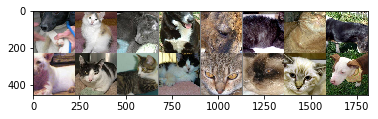

In [15]:
img = torchvision.utils.make_grid(image)
img = img.numpy().transpose(1,2,0)
mean = [0.5,0.5,0.5]
std  = [0.5,0.5,0.5]
img = img*std+mean
print("Pred Label:",[classes[i] for i in pred])
plt.imshow(img)